In [6]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from projimmo.data import *
from projimmo.preprocessor import *
from projimmo.model import *
from projimmo.optimize_model import *

In [7]:
query = f"""
        SELECT *
        FROM `{GCP_PROJECT}`.{BQ_DATASET}.DVF_{DATA_YEAR}
    """
#chemin d'accès à nos fichiers locaux
data_query_cache_path=Path(f"raw_data/valeursfoncieres-2023.txt")

# import de nos data, ici à partir du fichier mais plus tard dans la base de data de bigquer
df= get_data_with_cache(query=query,
gcp_project=GCP_PROJECT,
        cache_path=data_query_cache_path,
        data_has_header=True
   )

#Pour écrire dans big query le df notre choix
#load_data_to_bq(
#        df_de_notre_choix,
 #       gcp_project=GCP_PROJECT,
 #       bq_dataset=BQ_DATASET,
 #       table=f'processed_{DATA_SIZE}',
 #       truncate=True
  #  )
#appel à la fonction clean_data
df_0=clean_data(df)
#appel à la fonction clean_outliers
df_1=clean_outliers(df_0)
#on passe notre df dans la pipeline
X_1=df_1.drop(columns="valeur_fonciere")
y_1=df_1.valeur_fonciere
df_2=preprocess_features(X_1)[0]



Load data from local CSV...
✅ Data loaded, with shape (3727005, 43)
✅ X_processed, with shape (74729, 40)


In [8]:
X_1.head(20)

,type_de_voie,nombre_de_lots,code_type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,month_mutation,year_mutation,somme_surface_carrez,departement
654,RUE,1,2,95.0,4.0,0.0,1,2023,97.70,13
1027,RUE,2,2,95.0,4.0,0.0,1,2023,94.79,13
1598,RUE,1,2,45.0,2.0,0.0,1,2023,46.87,13
2101,AUTRE,1,2,58.0,3.0,0.0,1,2023,60.30,13
2112,RUE,1,2,65.0,3.0,0.0,2,2023,64.20,13
2268,RUE,1,2,93.0,3.0,0.0,1,2023,109.20,13
2564,RUE,1,2,61.0,2.0,0.0,1,2023,67.23,13
2781,RTE,1,2,100.0,5.0,0.0,1,2023,120.67,13
2998,RUE,1,2,80.0,4.0,0.0,1,2023,76.65,13
3374,RTE,1,2,48.0,3.0,0.0,1,2023,39.03,13


In [9]:
df_2.shape

(74729, 40)

In [10]:
df_1.head(20)
df_1.valeur_fonciere.max(),df_1.valeur_fonciere.min()

(14.757469426450479, 9.952325334619427)

In [11]:
min_value = df_1['valeur_fonciere'].min()

# Compter combien de valeurs correspondent à la valeur minimale
count_min = (df_1['valeur_fonciere'] == min_value).sum()

print(f"Nombre de valeurs égales à la valeur minimale : {count_min}")

Nombre de valeurs égales à la valeur minimale : 7


In [12]:
df_1.valeur_fonciere.mean()

12.33495615511633

In [13]:
df_1.valeur_fonciere.median()

12.273735966890268

# 1. Baseline

#### MOYENNE: 12.33
#### MAX, MIN:(14.7679, 9.95)
#### MEDIAN: 12.27



In [14]:
def plot_learning_curves(X_train, X_test, y_train, y_test, model, model_type):
    train_errors, test_errors = [], []
    train_sizes = np.linspace(0.1, 1.0, 10)

    for train_size in train_sizes:
        X_train_subset = X_train[:int(train_size * len(X_train))]
        y_train_subset = y_train[:int(train_size * len(y_train))]

        model.fit(X_train_subset, y_train_subset)

        y_train_pred = model.predict(X_train_subset)
        y_test_pred = model.predict(X_test)

        train_errors.append(mean_squared_error(y_train_subset, y_train_pred))
        test_errors.append(mean_squared_error(y_test, y_test_pred))

    plt.plot(train_sizes, train_errors, label='Train Error')
    plt.plot(train_sizes, test_errors, label='Test Error')
    plt.title(f'Learning Curves for {model_type}')
    plt.xlabel('Training Size')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

In [15]:
def pre_model(X,y,model_type):
    X_train,X_test,y_train,y_test=split_df(X,y)

    model=initialize_model(model_type)
    # Effectuer la validation croisée
    cv_results = cross_validate_model(X_train, y_train, model)
    print("\nSans validation croisée:")
    fitted_model=train_model(X_train,y_train,model)
    plot_learning_curves(X_train, X_test, y_train, y_test, fitted_model, model_type)
    metrics=evaluate_model(X_test,y_test,fitted_model, model_type)
    return metrics

# 2. XGB sans optimisation des paramètres

Validation croisée :
MSE moyen: 0.17
Écart-type du MSE: 0.00

Sans validation croisée:


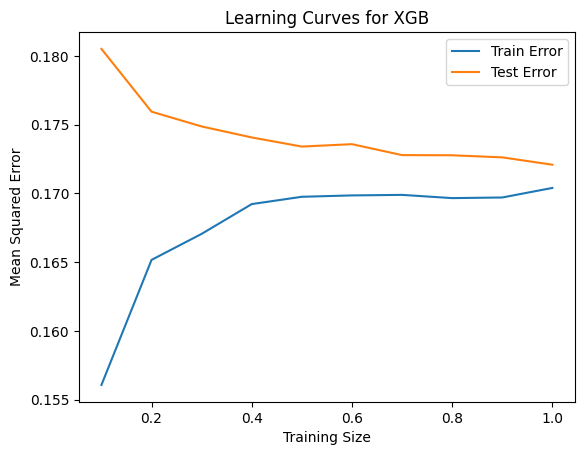

Mean Squared Error (MSE): 0.17208760961886174
Mean Absolute Error (MAE): 0.2916694790031261
R-squared (R²) Score: 0.6848128182652362
Root Mean Squared Error (RMSE): 0.4148344363946438
Mean Squared Logarithmic Error (MSLE): 0.00099752168855749


In [16]:
X=df_2.copy()
y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"
metrics_xgb=pre_model(X,y,model_type)


# 3. Opitmisation des paramètres

In [17]:
X=df_2.copy()
y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"
X_train,X_test,y_train,y_test=split_df(X,y)

model=initialize_model(model_type)
best_params=grid_search(X_train, y_train, model_type,model)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for XGB: {'eta': 0.1, 'max_depth': 6, 'n_estimators': 150}
Best score for XGB: 0.17026823631283358


In [12]:
best_params['eta']

0.2

Validation croisée :
MSE moyen: 0.17
Écart-type du MSE: 0.00


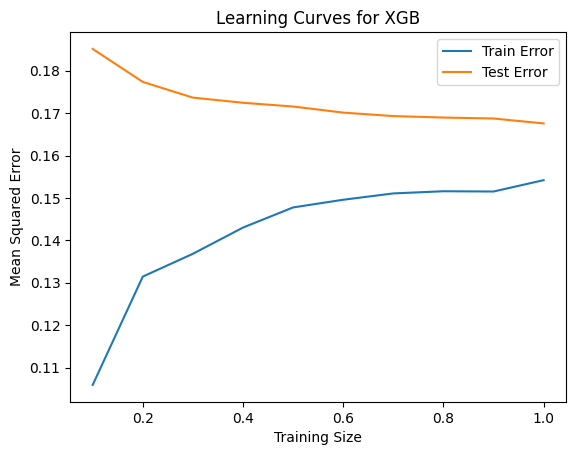

Mean Squared Error (MSE): 0.1675701297697888
Mean Absolute Error (MAE): 0.2888321841524235
R-squared (R²) Score: 0.6930868116417869
Root Mean Squared Error (RMSE): 0.4093533067776402
Mean Squared Logarithmic Error (MSLE): 0.0009723615208666533


{'mse': 0.1675701297697888,
 'mae': 0.2888321841524235,
 'r2': 0.6930868116417869,
 'rmse': 0.4093533067776402,
 'msle': 0.0009723615208666533}

In [18]:
eta=best_params['eta']
max_depth=best_params['max_depth']
n_estimators=best_params['n_estimators']
model_type="XGB"
n_components=35
X=df_2.copy()
y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"
model_XGB_opti=initialize_model(model_type, max_depth=max_depth, eta=eta, n_estimators=n_estimators)

X_train,X_test,y_train,y_test=split_df(X,y)

# Validation croisée sur les données transformées par PCA
cv_results_XGB_opti = cross_validate_model(X_train, y_train, model_XGB_opti)

# Entraîner le modèle sur les données réduites
fitted_model_XGB_opti = train_model(X_train, y_train, model_XGB_opti)
plot_learning_curves(X_train, X_test, y_train, y_test, fitted_model_XGB_opti, model_type)

# Évaluer le modèle sur les données de test transformées
metrics_XGB_opti = evaluate_model(X_test, y_test, fitted_model_XGB_opti, model_type)


metrics_XGB_opti

In [20]:
df_xgb_opti = pd.DataFrame(metrics_XGB_opti, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df_xgb_opti.rename(index={0: 'XGB avec meilleurs paramètres'}),
])
compa

,mse,mae,r2,rmse,msle
XGB,0.172088,0.291669,0.684813,0.414834,0.000998
XGB avec meilleurs paramètres,0.167570,0.288832,0.693087,0.409353,0.000972
